# Measure and parameterize dropoff in $f_{features}$ for FERENGI-fied images in Galaxy Zoo: Hubble

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from astropy.table import Table
from astropy.io import fits
from scipy import optimize
from scipy.stats import distributions as dist
import numpy as np
import os
import requests
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=UserWarning, append=True)

In [2]:
# Load data from Dropbox folder instead of clogging up Github

def download_from_dropbox(url):
    
    local_filename = "../data/{:}".format(url.split("/")[-1].split("?")[0])
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
            
    return local_filename

In [46]:
# Use only galaxies with surface brightness/redshift ranges that are considered "debiasable"
# This table is computed from p_features_thresholds.ipynb

#ferengi_filename = "../data/ferengi_debiasable_data.fits"
#if not os.path.exists(ferengi_filename):
#ferengi_filename = download_from_dropbox("https://www.dropbox.com/s/ayhz1vx3b17p4y7/ferengi_data.fits?dl=1")
ferengi_filename = download_from_dropbox("https://www.dropbox.com/s/afif9k0gwihus3a/ferengi_data_with_categories.fits?dl=1")
alldata = Table.read(ferengi_filename)    

data = alldata[alldata['Correctable_Category'] != 'uncorrectable']

# Limit to galaxies that have data at z_sim = z0, since that's what we're normalizing to.
z0 = 0.3
unique_galaxies = set(data['sdss_id'])
z0ind = np.zeros(len(data),dtype=bool)
eps = 1e-3
for ug in unique_galaxies:
    ind = (data['sdss_id'] == ug)
    if data[ind]['sim_redshift'].min() < (z0+eps):
        z0ind[ind] = True
        
data_z0 = data[z0ind]

##### "Zeta method"

Assume that the change in $f_{features}$ as a function of redshift can be parameterized as:

$\frac{f_f}{f_{f,z=z_0}} = e^{-\frac{(z-z_0)}{\zeta}}$

where $z_0=0.3$ is the lowest redshift in the FERENGIed images.

In [47]:
def fzeta_exp(p,x):
    
    #y = p[0] * np.exp(-1 * (x-p[1])/p[2])
    
    y = np.exp(-1 * (x-z0)/p[0])

    return y
    
def fzeta_lin(p,x):
    
    y = p[0] + p[1] * x

    return y

def fzeta(p,x):
    
    # Results are qualitatively the same for both lin and exp versions (should show this explicitly)
    # Use the exponential version for now.
    
    return fzeta_exp(p,x)

def errfunc(p,x,y,s):
    
    err = (y - fzeta(p,x))/s

    return err

def errfunc_lin(p,x,y,s):
    
    err = (y - fzeta_lin(p,x))/s

    return err

def error_bars(k,n=40,c=0.683):

    f_gal_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    f_gal_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    f_gal_err = (f_gal_upper - f_gal_lower) / 2.0
    
    return f_gal_err

def common_labels(fig,xlabel=None,ylabel=None,xfontsize=12,yfontsize=12):

    # Set common labels
    cax = fig.add_subplot(111)    # The big subplot
    cax.set_axis_bgcolor('none')
    cax.spines['top'].set_color('none')
    cax.spines['bottom'].set_color('none')
    cax.spines['left'].set_color('none')
    cax.spines['right'].set_color('none')
    cax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    cax.set_xlabel(xlabel,fontsize=xfontsize)
    cax.set_ylabel(ylabel,fontsize=yfontsize)

    return cax

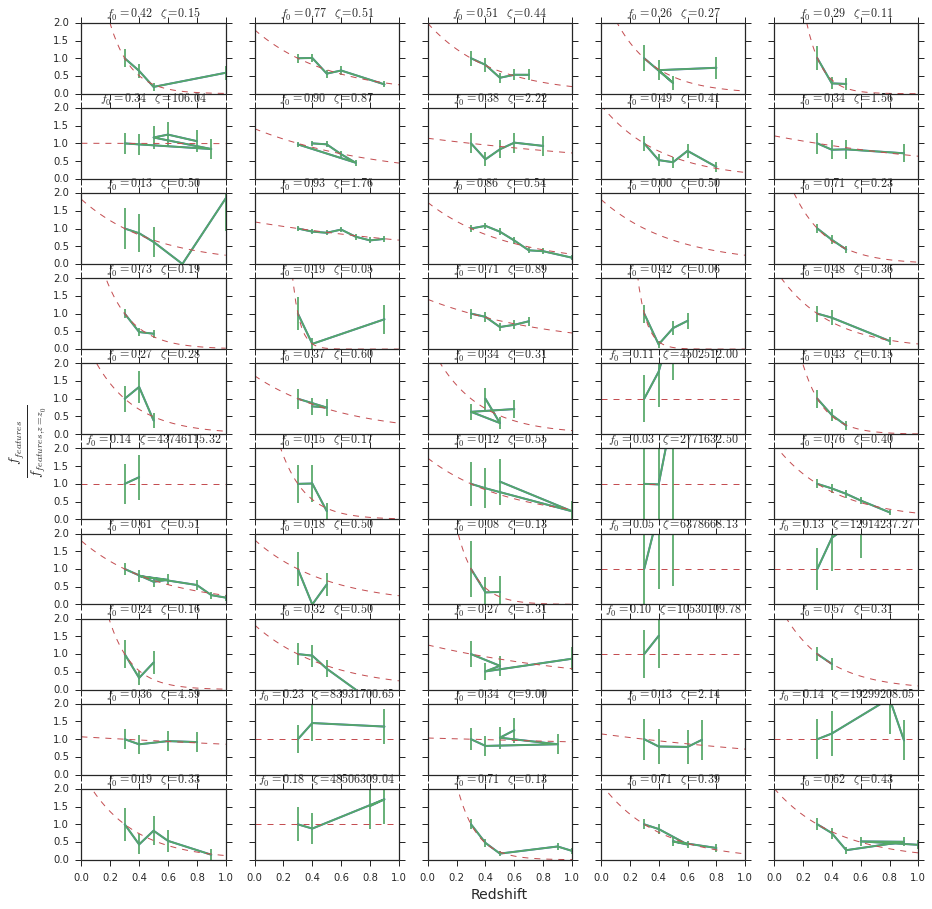

In [48]:
p_guess = np.array([0.5])

# Set up plot
fig,axarr = plt.subplots(nrows=10,ncols=5,sharex=True,sharey=True,figsize=(15,15))
bigax = common_labels(fig,'Redshift',r'$\frac{f_{features}}{f_{features,z=z_0}}$',14,20)
zarr = np.linspace(0,1,50)

# For examples, only plot galaxies with an evolution correction of zero.
evol = 0.0
e0 = data_z0[np.absolute(data_z0['sim_evolution'] - evol) < 0.001]
unique_galaxies = set(e0['sdss_id'])

for ax in axarr.ravel():
    
    slen = 0
    # Make sure there are enough points to fit a function
    while slen < (len(p_guess)+1):
        ind = (e0['sdss_id'] == unique_galaxies.pop())
        slen = sum(ind)
        
    galaxy1 = e0[ind]

    z_gal = galaxy1['sim_redshift']
    f_gal = galaxy1['p_features']
    
    #  ADD ERROR BARS
    n = 40  # assume 40 classifications per galaxy; it'd be better to use true value, though
    f_gal_err = error_bars(f_gal*n,n)
    f_gal_norm = f_gal / f_gal[0]
    f_gal_norm_err = np.sqrt((f_gal_err/f_gal)**2 + (f_gal_err[0]/f_gal[0])**2) * f_gal_norm

    # Values must be explicitly cast as double-type precision for optimization to work. Incredibly frustrating.
    # Fix: http://stackoverflow.com/questions/12473406/scipy-optimize-leastsq-returns-best-guess-parameters-not-new-best-fit 

    p, cov, infodict, mesg, ier = optimize.leastsq(errfunc,p_guess,args=(z_gal.astype(np.float64),
                                                                         f_gal_norm.astype(np.float64),
                                                                         f_gal_norm_err.astype(np.float64)),
                                                   full_output=1)
    ax.plot(z_gal,f_gal_norm,lw=2)
    ax.errorbar(z_gal,f_gal_norm, f_gal_norm_err)
    ax.plot(zarr,fzeta_exp(p,zarr),'--',lw=1)
    ax.set_title('$f_0={:.2f}\; \zeta={:.2f}$'.format(f_gal[0], p[0]))
    ax.set_xlim(0,1)
    ax.set_ylim(0,2)

In [49]:
# Find zeta for all images

data_z0['zeta'] = np.ones(len(data_z0)) * -99
data_z0['delchisq'] = np.ones(len(data_z0)) * -99

for gal in unique_galaxies:
    
    # Loop over evolution corrections
    
    for evo in set(data_z0['sim_evolution']):
        
        # Find data for this galaxy at all redshifts
        
        ind = (data_z0['sdss_id'] == gal) & (np.absolute(data_z0['sim_evolution'] - evo) < 0.001)
        
        # Make sure there are enough points to fit a function
        if sum(ind) > 3:
        
            galaxy1 = data_z0[ind]
            
            z_gal = galaxy1['sim_redshift']
            f_gal = galaxy1['p_features']
            
            #  ADD SOME ROUGH ERROR BARS
            f_gal_err = error_bars(f_gal*n,n)
            f_gal_norm = f_gal / f_gal[0]
            f_gal_norm_err = np.sqrt((f_gal_err/f_gal)**2 + (f_gal_err[0]/f_gal[0])**2) * f_gal_norm
            
            try:
                p, cov = optimize.leastsq(errfunc,p_guess,args=(z_gal.astype(np.float64),f_gal_norm.astype(np.float64),
                                                                f_gal_norm_err.astype(np.float64)))
                zeta = p[0]
                chisq = (((f_gal_norm - fzeta(p,z_gal)) / f_gal_norm_err)**2).sum()
                chisq_const = (((f_gal_norm - f_gal_norm.mean()) / f_gal_norm_err)**2).sum()
                delchisq = chisq_const - chisq
            except TypeError:
                print 'Galaxy %s has only %i redshifted images' % (galaxy1['sdss_id'][0],len(z_gal))
                zeta = -99.
                
            # Add zeta values to the larger table
            data_z0['zeta'][ind] = p[0]
            data_z0['delchisq'][ind] = delchisq

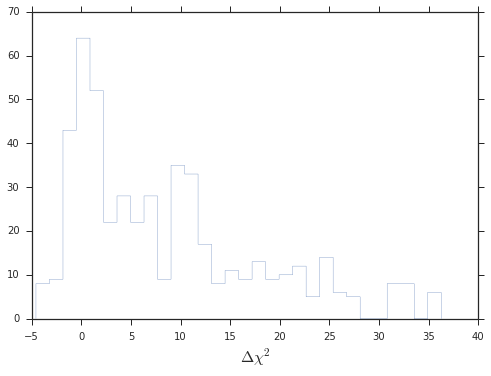

In [50]:
# Plot the distribution of delta chi^2
_ = plt.hist(data_z0['delchisq'][data_z0['delchisq']>-5], 30, histtype='step')
plt.xlabel(r"$\Delta \chi^2$",fontsize=16);

In [51]:
# How many galaxies have well-measured zeta values?

print '%i galaxies have well-measured zeta values' % ((data_z0['zeta'] < 10.) & (data_z0['zeta'] > -99.)).sum()
print '%i galaxies have zeta = -99' % (data_z0['zeta'] == -99.).sum()
print len(data_z0['zeta'])

469 galaxies have well-measured zeta values
1719 galaxies have zeta = -99
2227


51 (12 unique) galaxies with measured zeta values.



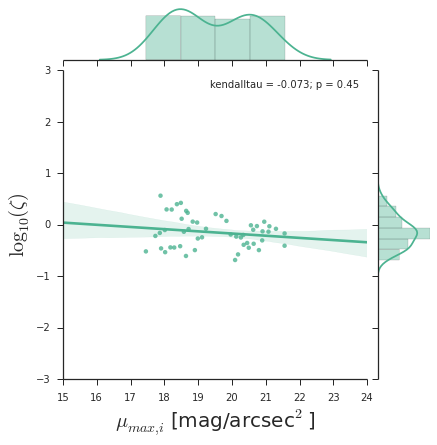

In [52]:
# Plot distribution of zeta as function of surface brightness
from scipy.stats import kendalltau
import seaborn as sns

sns.set(style="ticks")

# Only select unique galaxies (zeta is the same for all evolution corrections)

dz3 = data_z0[(data_z0['sim_redshift'] == z0) & (data_z0['p_features'] >= 0.0) & (data_z0['delchisq'] > 3.0)]

# Limit zeta to "sensible" values
zetalim = dz3[(dz3['zeta'] < 10.) & (dz3['zeta'] > -98.)]
x = zetalim['mu_max_i']
y = np.log10(zetalim['zeta'])
print "%i (%i unique) galaxies with measured zeta values.\n" % (len(zetalim),len(set(zetalim['sdss_id'])))

jg = sns.jointplot(x, y, kind="reg", stat_func=kendalltau, color="#4CB391")
jg.set_axis_labels(r'$\mu_{max,i}$ [mag/arcsec$^2$]',r'$\log_{10}(\zeta)$',fontsize=20);

In [53]:
fit = jg.ax_joint.lines[0].get_data()
x0,y0 = fit[0][0],fit[1][0]
x1,y1 = fit[0][-1],fit[1][-1]

# Slope, intercept where x = SB, y = log_10(zeta)
slope = (y1-y0)/(x1-x0)
intercept = y1 - slope*x1

$\log_{10}\zeta = m\mu + b$

$\zeta = 10^{m\mu + b}$

In [54]:
print('zeta = {:.1f} is a reasonable first order correction'.format(10**y.mean()))
print('For a slightly improved correction, fit with the linear function such that log_10(zeta) = ({:.4f} * SB) + {:.4f}'.format(slope,intercept))

zeta = 0.7 is a reasonable first order correction
For a slightly improved correction, fit with the linear function such that log_10(zeta) = (-0.0425 * SB) + 0.6800


### OK. We have a fit for $\zeta$ based on the SB-$z$ space that should be correctable. Now to actually *correct* all the Hubble data based on this trend!

In [38]:
# Download stripped-down version of the full GZH table. 
# Contains only OBJNO, survey, redshift, mu_hi, p_features, and categorization from FERENGI galaxies

hst_filename = "../data/gzh_task01_categorized.fits"
if not os.path.exists(hst_filename):
    hst_filename = download_from_dropbox("https://www.dropbox.com/s/84hwl9171puxla5/gzh_task01_categorized.fits?dl=1")
hstdata = Table.read(hst_filename,format='fits')

#hstdata_debiasable = hstdata[(hstdata['Correctable_Category'] == 'correctable') | (hstdata['Correctable_Category'] == 'nei')]
# Very stupid error where whitespace in file isn't being stripped.
hstdata = hstdata[hstdata['Correctable_Category'] == 'correctable       ']

$\hat\zeta = \zeta_0 + \zeta_1 \times SB$

$\hat f = f \times e^{(z-z_0)/{\hat\zeta}}$

# Mel's function (bounded between f and 1):

$\hat f = 1 - (1-f)e^{-(z-z_0)/{\hat\zeta}}$

In [39]:
def fhat(f,z,zeta_hat=0.5):
    
    val = f * np.exp((z - z0)/ zeta_hat)
    
    return val

def fhat_mel(f,z,zeta_hat=0.5):
    
    val = 1. - (1. - f)*np.exp(-(z - z0)/ zeta_hat)
    
    return val

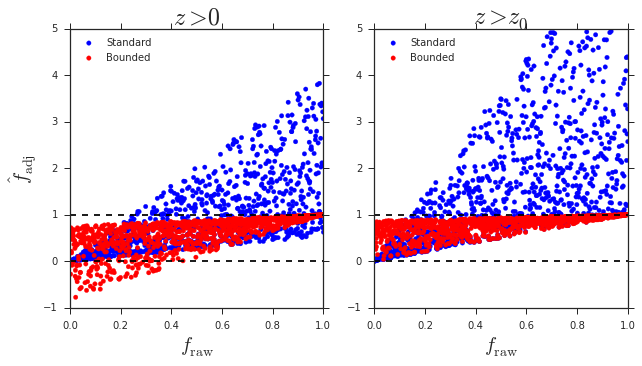

In [40]:
# Test the behavior of the functions for a random array of p_features and redshifts

xarr = np.arange(0,1.001,0.001)
zarr = np.random.rand(len(xarr))
zarr_bounded = np.random.rand(len(xarr))+z0

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.scatter(xarr,fhat(xarr,zarr),color='b',label='Standard')
ax1.scatter(xarr,fhat_mel(xarr,zarr),color='r',label='Bounded')
ax1.set_xlabel(r'$f_{\rm raw}$',fontsize=20)
ax1.set_ylabel(r'$\hat f_{\rm adj}$',fontsize=20)
ax1.set_title(r'$z > 0$',fontsize=24)
ax1.hlines(1,0,1,linestyle='--')
ax1.hlines(0,0,1,linestyle='--')
ax1.set_xlim(0,1)
ax1.set_ylim(-1,5)
ax1.legend(loc='upper left')
ax2 = fig.add_subplot(122)
ax2.scatter(xarr,fhat(xarr,zarr_bounded),color='b',label='Standard')
ax2.scatter(xarr,fhat_mel(xarr,zarr_bounded),color='r',label='Bounded')
ax2.hlines(1,0,1,linestyle='--')
ax2.hlines(0,0,1,linestyle='--')
ax2.set_xlim(0,1)
ax2.set_ylim(-1,5)
ax2.set_xlabel(r'$f_{\rm raw}$',fontsize=20)
ax2.set_title(r'$z > z_0$',fontsize=24)
ax2.legend(loc='upper left');

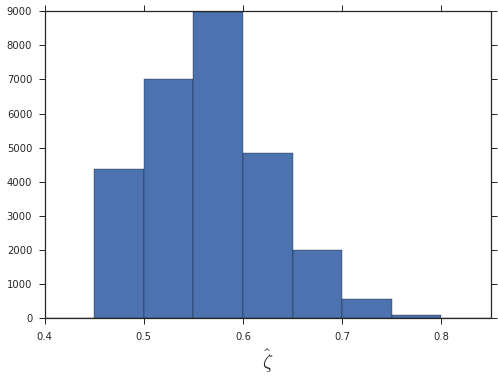

In [55]:
# Plot distribution of zeta_hat values from GZH

mu = hstdata['MU_HI']
zeta_hat = 10**(slope * mu + intercept)
plt.hist(zeta_hat[np.isfinite(zeta_hat)],bins=40,range=(0,2))
plt.xlabel(r'$\hat\zeta$',fontsize=20);

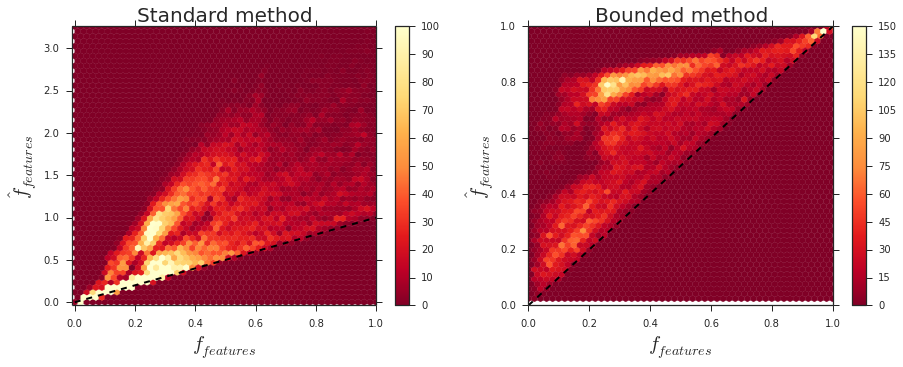

In [56]:
# Plot 2d histogram of old vs new p_features, using both the standard and bounded equations

old = hstdata['p_features']
new = fhat(old,hstdata['Z'],zeta_hat)
good_z = (hstdata['Z'] > 0.) & (hstdata['Z'] < 9.)
bad_z = (hstdata['Z'] > 0.) & (hstdata['Z'] < 9.) 

# Use standard fhat function
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
hex1 = ax1.hexbin(old[good_z],new[good_z], cmap=plt.cm.YlOrRd_r,gridsize=50,vmax=100)
ax1.set_xlabel(r'$f_{features}$',fontsize=20)
ax1.set_ylabel(r'$\hat f_{features}$',fontsize=20)
cb1 = plt.colorbar(hex1)
ax1.set_title('Standard method',fontsize=20)

# Add the one-to-one line for comparision.
# Upper left = boosted p_features for z > z0
# Lower right = depressed p_features for z < z0

ax1.plot([0,1],[0,1],color='k',lw=2,ls='--')

# Use bounded fhat function
new2 = fhat_mel(old,hstdata['Z'],zeta_hat)
ax2 = fig.add_subplot(122)
hex2 = ax2.hexbin(old,new2,cmap=plt.cm.YlOrRd_r,gridsize=50)
ax2.set_xlabel(r'$f_{features}$',fontsize=20)
ax2.set_ylabel(r'$\hat f_{features}$',fontsize=20)
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
cb2 = plt.colorbar(hex2)
ax2.plot([0,1],[0,1],color='k',lw=2,ls='--')
ax2.set_title('Bounded method',fontsize=20);

In [57]:
print "{:d} out of {:d} galaxies using the bounded method have adjusted f_features < 0.".format(good_z.sum(),good_z.sum())

27838 out of 27838 galaxies using the bounded method have adjusted f_features < 0.
